Interprétabilité locale sur des images

In [3]:
# Import des librairies
# Base
%matplotlib inline
import numpy as np # type: ignore
import pandas as pd # type: ignore
import time,os
import cv2# type: ignore
# Data Viz
import matplotlib.pyplot as plt# type: ignore
# Modèle
import tensorflow as tf# type: ignore
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,MaxPool2D# type: ignore
from keras import layers, models, optimizers, losses, metrics,callbacks,utils,Model,Sequential,Input# type: ignore
print("tensorflow version",tf.__version__)
import shap
#import mlflow

tensorflow version 2.16.1


In [31]:
# Configuration pour les performances afin d'éviter une saturation de la RAM
options = tf.data.Options()

# Stop magic stuff that eats up RAM:
options.autotune.enabled = False
options.experimental_distribute.auto_shard_policy = (
  tf.data.experimental.AutoShardPolicy.OFF)
options.experimental_optimization.inject_prefetch = False

In [4]:

from tensorflow.keras.models import load_model
logged_model = r'\\wsl.localhost\Ubuntu\home\adrien\MLflow\mlruns\902956440979823799\965c82771e144a14a8ed9875930dd581\artifacts\model'
cnn=load_model(logged_model+"/data/model.keras")   
cnn.summary()

d:\Adrien et Sarah\Documents\GitHub\JAN24_PLANT_RECOGNITION\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 40 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 8, 8, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │        38,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,424,270 (177.09 MB)

 Trainable params: 23,212,134 (88.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,212,136 (88.55 MB)

Nous obtenons la sortie de la dernière couche de convolution. Nous créons ensuite un modèle qui remonte uniquement à cette couche.

In [19]:
#Data normalization
def my_preprocessing_func(img):
    img = np.array(img)
    return img / 255
def my_preprocessing_func2(img):
    image = np.array(img)
    image=image.astype(np.uint8)
    return image
def my_preprocessing_func3(img):
    image = np.array(img)
    image=image.astype(np.float32)
    return image/255

In [15]:
print('getcwd: ', os.getcwd())
directory1=(r"D:\Adrien et Sarah\Documents\GitHub\models\DATASETS\Maladie_sur_les_plantes\03_Plant_Diseases_Dataset_off_outliers\train")
print('le filename de img_color est :', directory1)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=my_preprocessing_func2)   
test = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=my_preprocessing_func)   

valid_generator = val_gen.flow_from_directory(
    directory=directory1,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=256,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
test_generator = test.flow_from_directory(
    directory=directory1,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=128,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


getcwd:  d:\Adrien et Sarah\Documents\GitHub\JAN24_PLANT_RECOGNITION\notebooks
le filename de img_color est : D:\Adrien et Sarah\Documents\GitHub\models\DATASETS\Maladie_sur_les_plantes\03_Plant_Diseases_Dataset_off_outliers\train
Found 68841 images belonging to 38 classes.
Found 68841 images belonging to 38 classes.


{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

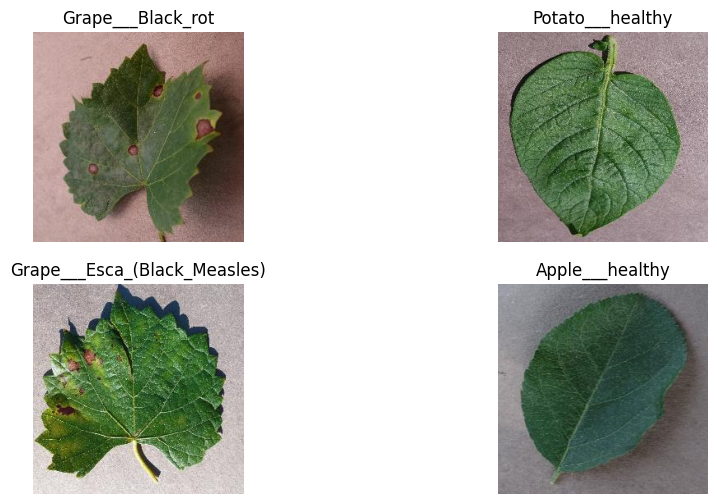

In [33]:
labels = (valid_generator.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
labell=list(labels.values())
#pd.DataFrame(labels.values()).to_csv("labels.csv")

x_train, y_train = next(valid_generator)
# Assuming X[8] contains integer data that needs to be scaled to the range [0, 255]
x_train = np.clip(x_train, 0, 255).astype(np.uint8)
y_train = [labels[k] for k in y_train.argmax(axis=1)]

fig, axes = plt.subplots(2,2, figsize = (11,6))
axes = axes.ravel()
for i in range (0,4):
    image = x_train[i] 
    axes[i].imshow(image)
    axes[i].set_title(y_train[i])
    axes[i].axis('off')
#plt.subplots_adjust(hspace=.1,wspace=3)


In [48]:
print(x_train.shape,x_train.dtype)
x_train

(256, 256, 256, 3) uint8


array([[[[148, 136, 136],
         [151, 139, 139],
         [154, 142, 142],
         ...,
         [152, 142, 143],
         [155, 145, 146],
         [158, 148, 149]],

        [[149, 137, 137],
         [150, 138, 138],
         [152, 140, 140],
         ...,
         [155, 145, 146],
         [155, 145, 146],
         [155, 145, 146]],

        [[150, 138, 138],
         [150, 138, 138],
         [149, 137, 137],
         ...,
         [156, 146, 147],
         [152, 142, 143],
         [150, 140, 141]],

        ...,

        [[111, 100,  98],
         [113, 102, 100],
         [104,  93,  91],
         ...,
         [108,  96,  96],
         [109,  97,  97],
         [122, 110, 110]],

        [[105,  94,  92],
         [102,  91,  89],
         [102,  91,  89],
         ...,
         [109,  97,  97],
         [110,  98,  98],
         [123, 111, 111]],

        [[110,  99,  97],
         [112, 101,  99],
         [119, 108, 106],
         ...,
         [123, 111, 111],
        

In [34]:
def f(x):
    tmp = x.copy()
    tmp=my_preprocessing_func3(tmp)
    #print("type:",tmp.dtype,tmp.shape,tmp.min(),tmp.max())
    return cnn(tmp)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", x_train[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=labell)

# here we explain two images using 1000 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    x_train[1:3], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

PartitionExplainer explainer: 3it [21:59, 659.83s/it]              


# output with shap values
shap.image_plot(shap_values)

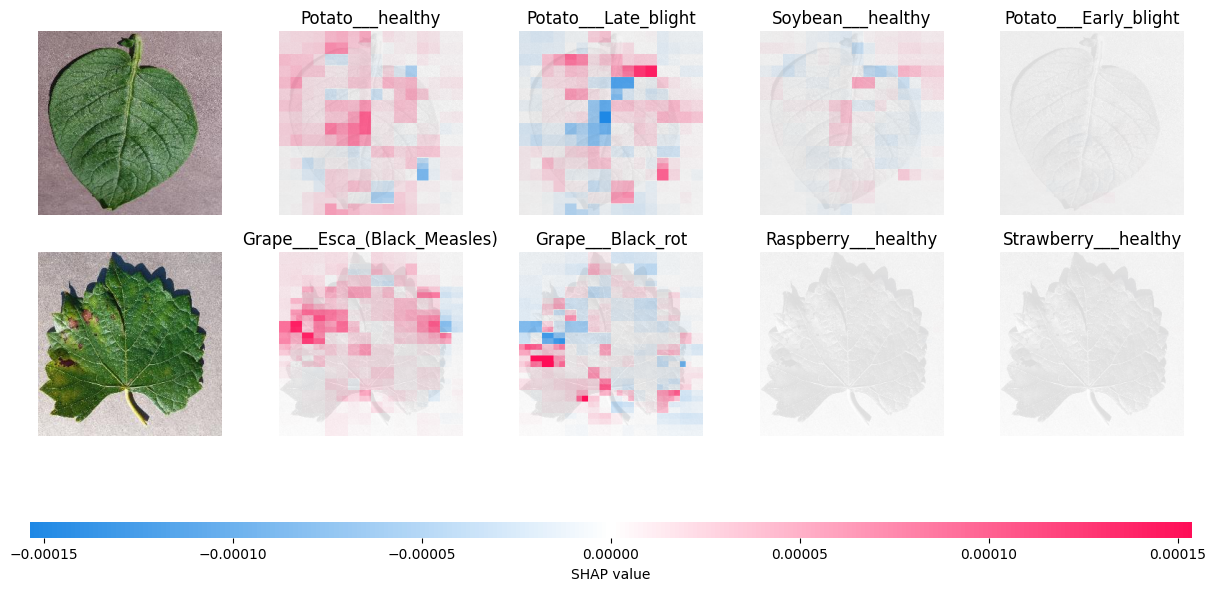

In [35]:
shap.image_plot(shap_values)

type: float32 (128, 256, 256, 3) 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


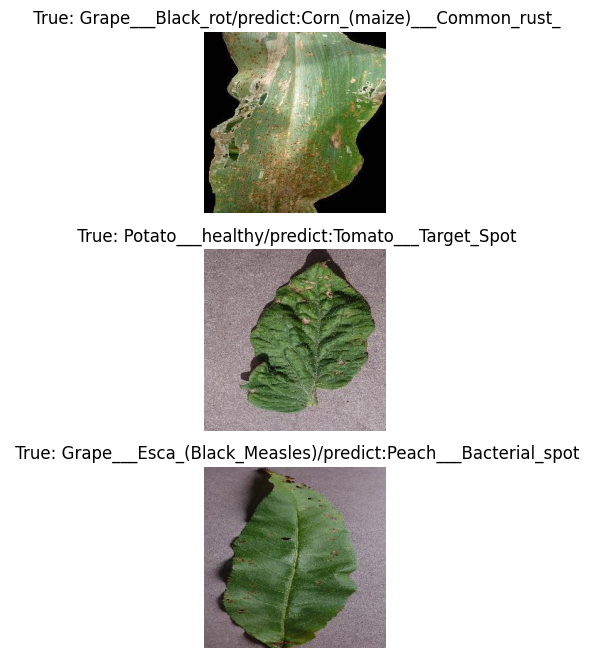

In [37]:
x_test, y_test = next(test_generator)
# Assuming X[8] contains integer data that needs to be scaled to the range [0, 255]
y_test = [labels[k] for k in y_test.argmax(axis=1)]
print("type:",x_test.dtype,x_test.shape,x_test.min())
fig, axes = plt.subplots(3,1, figsize = (5,8))
axes = axes.ravel()
pred=cnn.predict(x_test[0:3])
predicted_class_indices=np.argmax(pred,axis=1)
for i,img in enumerate(x_test[0:3]):
    axes[i].imshow(img)
    axes[i].set_title(f" True: {y_train[i]}/predict:{labels[predicted_class_indices[i]]}")
    axes[i].axis('off')



In [38]:
y_train

['Grape___Black_rot',
 'Potato___healthy',
 'Grape___Esca_(Black_Measles)',
 'Apple___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Apple___Black_rot',
 'Tomato___healthy',
 'Potato___Late_blight',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Tomato___Leaf_Mold',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Leaf_Mold',
 'Apple___Black_rot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Leaf_Mold',
 'Strawberry___Leaf_scorch',
 'Cherry_(including_sour)___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Potato___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Peach___Bacterial_spot',
 'Apple___healthy',
 'Potato___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Tomato___Tomato_mosaic_virus',
 'Apple___Apple_scab',
 'Corn_(maize)___Common_rust_',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Potato___Late_blight',
 'Corn_(maize)___healthy',
 'Grape___healthy',
 'Potato___heal